In [33]:
import os
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.io import read_image
from torchsummary import summary

from tqdm import tqdm
from datetime import datetime
from sklearn.model_selection import train_test_split

device = "cpu"
if torch.cuda.is_available():
    device="cuda"

In [34]:
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.info = df
        self.transform = transform

    def __len__(self):
        return len(self.info)

    def __getitem__(self, idx):
        path = self.info.imgPath.values[idx]
        label = self.info['class'].values[idx]
        image = read_image(path, mode=torchvision.io.image.ImageReadMode.RGB).float()

        if self.transform:
            image = self.transform(image)

        return image, label

In [35]:
df= pd.read_csv("breastCancerDataframe.csv", index_col=0)
print(df.head())

patientIDs = df.patient.unique()
print("Number of Unique Patients: ", len(patientIDs))

patients_train, temp = train_test_split(patientIDs, test_size=0.3, random_state=42)
patients_val, patients_test = train_test_split(temp, test_size=0.5, random_state=42)

df_train = df.loc[df['patient'].isin(patients_train)]
print(df_train.head())
print("Number of Train Patients: ", df_train.patient.nunique())

df_val = df.loc[df['patient'].isin(patients_val)]
print(df_val.head())
print("Number of Validation Patients: ", df_val.patient.nunique())

df_test = df.loc[df['patient'].isin(patients_test)]
print(df_test.head())
print("Number of Test Patients: ", df_test.patient.nunique())

   patient  class  posX  posY                                         imgPath
0    12954      0  1151  1401  data/12954/0/12954_idx5_x1151_y1401_class0.png
1    12954      0  1951  2901  data/12954/0/12954_idx5_x1951_y2901_class0.png
2    12954      0   151   501    data/12954/0/12954_idx5_x151_y501_class0.png
3    12954      0  1701  2251  data/12954/0/12954_idx5_x1701_y2251_class0.png
4    12954      0  1501  2001  data/12954/0/12954_idx5_x1501_y2001_class0.png
Number of Unique Patients:  279
   patient  class  posX  posY                                         imgPath
0    12954      0  1151  1401  data/12954/0/12954_idx5_x1151_y1401_class0.png
1    12954      0  1951  2901  data/12954/0/12954_idx5_x1951_y2901_class0.png
2    12954      0   151   501    data/12954/0/12954_idx5_x151_y501_class0.png
3    12954      0  1701  2251  data/12954/0/12954_idx5_x1701_y2251_class0.png
4    12954      0  1501  2001  data/12954/0/12954_idx5_x1501_y2001_class0.png
Number of Train Patients:  195
 

In [36]:
BATCH_SIZE = 128

transform = transforms.Compose([
        #transforms.RandomRotation(45),
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_dataset = CustomImageDataset(df_train, transform=transform)
val_dataset = CustomImageDataset(df_val, transform=transform)
test_dataset = CustomImageDataset(df_test, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

In [9]:
"""
model=models.resnet18(pretrained=True)
print(model)

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),

    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),

    nn.Linear(256, 1))

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)
"""

'\nmodel=models.resnet18(pretrained=True)\nprint(model)\n\nmodel.fc = nn.Sequential(\n    nn.Linear(model.fc.in_features, 512),\n    nn.ReLU(),\n    nn.BatchNorm1d(512),\n    nn.Dropout(0.5),\n\n    nn.Linear(512, 256),\n    nn.ReLU(),\n    nn.BatchNorm1d(256),\n    nn.Dropout(0.5),\n\n    nn.Linear(256, 1))\n\ndef init_weights(m):\n    if type(m) == nn.Linear:\n        torch.nn.init.xavier_uniform_(m.weight)\n        m.bias.data.fill_(0.01)\n\nmodel.apply(init_weights)\n'

In [37]:
model = models.efficientnet_b0(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(1280, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),

    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),

    nn.Linear(256, 1))

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)
#summary(model, (3,224,224))

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [39]:
# Calculate performance measures
def compute_performance(yhat, y, pos_cutoff):

    # First, get tp, tn, fp, fn
    tp = sum(np.logical_and(yhat >= pos_cutoff, y == 1).numpy())
    tn = sum(np.logical_and(yhat < pos_cutoff, y == 0).numpy())
    fp = sum(np.logical_and(yhat >= pos_cutoff, y == 0).numpy())
    fn = sum(np.logical_and(yhat < pos_cutoff, y == 1).numpy())

    print(f"tp: {tp} tn: {tn} fp: {fp} fn: {fn}")

    # Accuracy
    #acc = (tp + tn) / (tp + tn + fp + fn)

    # Precision
    # "Of the ones I labeled +, how many are actually +?"
    precision = tp / (tp + fp)

    # Recall
    # "Of all the + in the data, how many do I correctly label?"
    recall = tp / (tp + fn)

    # Sensitivity
    # "Of all the + in the data, how many do I correctly label?"
    sensitivity = recall

    # Specificity
    # "Of all the - in the data, how many do I correctly label?"
    specificity = tn / (fp + tn)

    balanced_acc = 0.5*(sensitivity+specificity)

    # Print results
    print("Balanced Accuracy: ", balanced_acc," Specificity: ",specificity,
          " Sensitivity: ",sensitivity," Precision: ",precision,)

#fMeasure =  2*((performance[1]*performance[2])/(performance[1]+performance[2]))

def train(model, device='cpu', epochs=10, early_stop=2, lr=0.001, verbose=True):

    opt = torch.optim.Adam(model.classifier.parameters(), lr=lr)
    #opt = torch.optim.Adam(model.fc.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    model.to(device)

    lowest_val_loss = np.inf
    lowest_val_epoch = 0
    epochs_wo_improvement = 0
    best_model = copy.deepcopy(model.state_dict())
    train_losses, val_losses=[], []

    for e in range(epochs):
        epoch_train_loss = 0
        epoch_val_loss = 0

        model.train()
        #with torch.autograd.profiler.profile() as prof:
        for inputs, targets in tqdm(train_dataloader):

            inputs, targets = inputs.to(device), targets.to(device)

            model.zero_grad(set_to_none=True)

            output = model.forward(inputs)
            loss = criterion(output.squeeze(), targets.float())
            loss.backward()
            opt.step()

            epoch_train_loss+=loss

        #print(prof.key_averages().table(sort_by="self_cpu_time_total"))

        epoch_train_loss = epoch_train_loss.item()/((len(df_train)%BATCH_SIZE)*BATCH_SIZE)

        train_losses.append(epoch_train_loss)

        #VALIDATION

        model.eval()
        val_preds, val_targets_list = [], []

        with torch.no_grad():
            for val_inputs, val_targets in tqdm(val_dataloader):

                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)

                model.zero_grad(set_to_none=True)

                val_output = model.forward(val_inputs).squeeze()
                val_preds+=val_output
                val_targets_list+=val_targets

                epoch_val_loss += criterion(val_output, val_targets.float())

            epoch_val_loss = epoch_val_loss.item()/((len(df_val)%BATCH_SIZE)*BATCH_SIZE)
            val_losses.append(epoch_val_loss)

            compute_performance(torch.sigmoid(torch.Tensor(val_preds)), torch.Tensor(val_targets_list), 0.5)

        if epoch_val_loss <= lowest_val_loss:
            best_model = copy.deepcopy(model.state_dict())
            lowest_val_loss = epoch_val_loss
            lowest_val_epoch=e
            epochs_wo_improvement=0
        else:
            epochs_wo_improvement+=1

        if verbose:
            print("Epoch: {}/{}...".format(e, epochs), "Loss: {:.4f}...".format(epoch_train_loss), "Val Loss: {:.4f}".format(epoch_val_loss),)

        #early stopping
        if epochs_wo_improvement>=early_stop:
            if verbose:
                print("Early Stop no improvement in validation loss in "+str(early_stop)+" validation steps")
            break

    if verbose:
        print("\nLowest Validation Loss: "+str(lowest_val_loss)+" at epoch "+str(lowest_val_epoch)+'\n')

    model.load_state_dict(best_model)

    return model, train_losses, val_losses

In [ ]:
torch.backends.cudnn.benchmark = True
model, train_losses, val_losses = train(model, device=device)

In [14]:
torch.save({'model_state_dict': model.state_dict()}, './BestModels/E_4_TL_0.3239_VL_0.0101.pt')

Percent Neg:  0.7270911259007103
Percent Pos:  0.2729088740992896
Neg Count:  142680 Pos Count:  53554

Class Percentages After Splitting
Percent Neg Train1:  0.47036018751112607 Percent Pos Train 1:  0.5296398124888739
Percent Neg Train2:  0.47036018751112607 Percent Pos Train 2:  0.5296398124888739
Percent Neg Train3:  0.47036018751112607 Percent Pos Train 3:  0.5296398124888739


c:\users\spencer\documents\pytorch\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\spencer\documents\pytorch\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\users\spencer\documents\pytorch\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  w

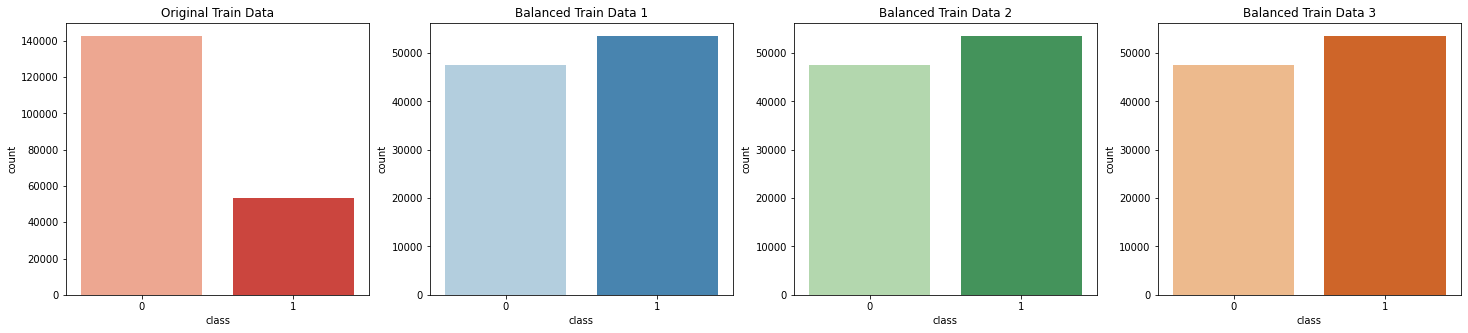

In [40]:
print("Percent Neg: ", (df_train['class'].to_list()).count(0)/len(df_train))
print("Percent Pos: ", (df_train['class'].to_list()).count(1)/len(df_train))

df_train_neg = df_train.loc[df_train['class']==0]
df_train_pos = df_train.loc[df_train['class']==1]
print("Neg Count: ", len(df_train_neg), "Pos Count: ",len(df_train_pos))

#split it into 3 since i would rater the model have an over represented positive class so the model
#predicts pos more than neg since identifying pos is more important
df_train1, temp = train_test_split(df_train_neg, train_size=1/3, random_state=42)
df_train2, df_train3 = train_test_split(temp, train_size=1/2, random_state=42)
df_train1 = pd.concat([df_train1, df_train_pos], ignore_index=True)
df_train2 = pd.concat([df_train2, df_train_pos], ignore_index=True)
df_train3 = pd.concat([df_train3, df_train_pos], ignore_index=True)


fig, ax = plt.subplots(1,4,figsize=(25,5))
sns.countplot(df_train['class'], ax=ax[0], palette="Reds")
ax[0].set_title("Original Train Data")
sns.countplot(df_train1['class'], ax=ax[1], palette="Blues")
ax[1].set_title("Balanced Train Data 1")
sns.countplot(df_train2['class'], ax=ax[2], palette="Greens")
ax[2].set_title("Balanced Train Data 2")
sns.countplot(df_train3['class'], ax=ax[3], palette="Oranges")
ax[3].set_title("Balanced Train Data 3")

print("\nClass Percentages After Splitting")
print("Percent Neg Train1: ", (df_train1['class'].to_list()).count(0)/len(df_train1), "Percent Pos Train 1: ", (df_train1['class'].to_list()).count(1)/len(df_train1))
print("Percent Neg Train2: ", (df_train2['class'].to_list()).count(0)/len(df_train2), "Percent Pos Train 2: ", (df_train2['class'].to_list()).count(1)/len(df_train2))
print("Percent Neg Train3: ", (df_train3['class'].to_list()).count(0)/len(df_train3), "Percent Pos Train 3: ", (df_train3['class'].to_list()).count(1)/len(df_train3))

train_dataset1 = CustomImageDataset(df_train1, transform=transform)
train_dataset2 = CustomImageDataset(df_train2, transform=transform)
train_dataset3 = CustomImageDataset(df_train3, transform=transform)

train_dataloader1 = DataLoader(train_dataset1, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
train_dataloader2 = DataLoader(train_dataset2, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
train_dataloader3 = DataLoader(train_dataset3, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)